In [2]:
import numpy as np
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import xgboost as xgb 
import structures
import numpy as np
from sklearn import metrics
from scipy.stats import uniform, randint
import seaborn as sns
from sklearn.metrics import auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, RocCurveDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
import joblib

In [3]:
sample_length = 1
df = pd.read_csv(rf'D:\eeg\maya\data\features_{sample_length}s.csv')
df = df.drop(['Sub P2P Diff', 'Sub P2P'], axis = 1) # exclude subject level features
#df = df.drop(['Sub P2P Diff', 'Sub P2P', 'MAV', 'ZCR', 'PAV', 'Peak Count'], axis = 1) #Exclude all but asymmetry features
model = model_type = rf"{len(df.columns)-2}_features"
df.head()

,Subject,Group,MAV,MAV Diff,ZCR,ZCR Diff,PAV,Peak Count,Peak Count Diff,Peak Amp. diff,Mean Peak Amp. Diff,Mean Peak Delay,STD Peak delay,P2P Diff,Max Corr,Mean Corr,mean absolute diff,Norm,Pearson
0,AA4,0,0.717235,0.208073,0.232,0.206897,1.535464,11.5,0.956522,1.145376,0.174419,67.666667,52.835173,2.481361,132.799323,0.435356,0.800240,15.732898,0.506924
1,AA4,0,0.717262,0.000705,0.198,0.141414,1.543598,11.5,0.086957,0.268195,0.025155,10.272727,12.548748,0.057959,174.371935,0.877698,0.623142,12.379666,0.694709
2,AA4,0,0.794056,0.101769,0.144,0.277778,1.560080,11.0,0.181818,0.654103,0.117284,36.200000,12.552291,0.241772,128.895876,-0.012080,0.806512,15.963312,0.492376
3,AA4,0,0.786719,0.018560,0.188,0.127660,1.599107,13.5,0.074074,0.710807,0.013580,12.769231,9.923971,0.301764,119.870662,-0.312298,0.828044,16.194403,0.477572
4,AA4,0,0.754740,0.052512,0.216,0.074074,1.549244,14.0,0.285714,0.893078,0.045379,16.333333,11.404190,0.278576,176.830231,-0.391126,0.613483,12.179472,0.704503


In [4]:
control = ['AA4',  'AD5', 'AD7',  'BP5',  'BZ4', 
           'DC9',  'KS6', 'LK4',  'LS8',  'MG1',
           'MK39', 'ML6', 'MU6',  'OS8',  'RA64', 
           'RS2', 'SA50', 'TBN8', 'VB10', 'YL02']
parkinsons = ['AC4',  'AH67', 'AP7', 'AS98', 'ED8',
              'HR67', 'MM4',  'NF1', 'RK4',  'RT1', 
              'SA7',  'SB2',  'TY0', 'VH5',  'VP2',
              'YAA0', 'YG2',  'YG8', 'YH8' , 'YP8',
              'YZ6',  'YZ64', 'ZZ0']

groups = [control, parkinsons]
group_names = ['control', 'parkinsons']

In [5]:
def evaluate(model,samples, labels):
    y_pred = model.predict(samples)

    return np.mean(y_pred == labels) 
    # print("Accuracy:", accuracy)

In [6]:
def evaluate_proba(model,samples, label, proba):
    y_pred = model.predict_proba(samples)
    correct = 0
    for i,pred in enumerate(y_pred):
        l = 0
        if pred[1]>=proba:
            l = 1
        if l == label:
            correct+=1
    if len(y_pred)>0:
        return correct/len(y_pred) 
    else:
        return 0

In [7]:
def cm(model,samples, label, proba):
    y_pred = model.predict_proba(samples)
    correct = 0
    for i,pred in enumerate(y_pred):
        l = 0
        if pred[1]>=proba:
            l = 1
        if l == label:
            correct+=1
    
    return correct, len(y_pred)-correct


In [8]:
def assessed_as_p(model,samples):
    y_pred = model.predict(samples)
    # train_pred = clf.predict(train_samples)
    # # Evaluate the model
    return np.mean(y_pred == 1) 
    # print("Accuracy:", accuracy)

In [9]:
def leave_one_out(data, subject):
    ''' Given a subject's name, set their samples as the test data and all other samples as train data'''
    test_data = data[data['Subject'] == subject]
    train_data = data.drop(data[data['Subject'] == subject].index)
    return train_data, test_data

In [10]:
def equalize_group_sizes(train_data):
        '''Given a data set with coloumn 'group' in it, containing only 2 group options, calculate the amount of samples for each group (the group's size)
           and the difference in size X. Then randomly remove X samples from the larger group and return a dataset with the same amount of samples for 
           each of the 2 groups'''
        group_counts = train_data['Group'].value_counts()

        # Find the group with more rows
        larger_group = group_counts.idxmax()
        smaller_group = group_counts.idxmin()

        # Calculate the difference in row count
        row_difference = group_counts[larger_group] - group_counts[smaller_group]

        # Randomly sample and remove excess rows from the larger group
        indices_to_remove = train_data[train_data['Group'] == larger_group].sample(row_difference).index
        return train_data.drop(indices_to_remove)

In [11]:
def seperate_samples_from_labels(train_data, test_data):
        ''' Given the train and test datasets, remove subject's name and from the data, seperate features from the label, and return them.'''
        train_y = train_data['Group']

        #Load X Variables into a Pandas Dataframe with columns 
        train_X = train_data.drop(['Group', 'Subject'], axis = 1)

        #train model
        test_X = test_data.drop(['Group', 'Subject'], axis = 1)
        test_y = test_data['Group']
        
        return train_X, train_y, test_X, test_y

## Leave One Out

### Train and save models

In [12]:
overall_confusion_matrix =np.zeros((2,2))
percent_parkinsons = [[0 for _ in range(20)], [0 for _ in range(23)]]
proba = 0.5
for idx, group in enumerate(groups):
    for i, subject in enumerate(group):
        train_data, test_data = leave_one_out(df ,subject)
        
        # Calculate the number of samples for each group
        train_data = equalize_group_sizes(train_data)

        #shuffle rows
        train_data = train_data.sample(frac = 1)

        X_train, y_train, X_test, y_test = seperate_samples_from_labels(train_data, test_data)
        # Create an XGBoost binary classification model
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
        # Fit the model to the training data
        xgb_model.fit(X_train, y_train)
        joblib.dump(xgb_model, rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\{subject}")

### Load Trained Models and Test

In [13]:
parkinsons_percent = [[0 for _ in range(20)], [0 for _ in range(23)]]
parkinsons_overall = [[0 for _ in range(20)], [0 for _ in range(23)]]
proba = 0.5
overall_confusion_matrix = np.zeros((2,2))
for i, group in enumerate(groups):
    for j, subject in enumerate(group):
        xgb_model = joblib.load(rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\{subject}") 
        train_data, test_data = leave_one_out(df ,subject)
        #Calculate the number of samples for each group
        train_data = equalize_group_sizes(train_data)
        #shuffle rows
        train_data = train_data.sample(frac = 1)
        X_train, y_train, X_test, y_test = seperate_samples_from_labels(train_data, test_data)
        correct, wrong = cm(xgb_model, X_test, i, proba)
        overall_confusion_matrix[i][i] += correct
        overall_confusion_matrix[i][1-i] += wrong
        #print(correct*100/(correct+wrong), wrong*100/(correct+wrong))
        accuracy = evaluate_proba(xgb_model, X_test, i, proba)
        parkinsons_percent[i][j] = accuracy if i == 1 else 1-accuracy # Accuracy if the true label is 1 (PD). Else 1-Accuracy, (1-Healthy)
        parkinsons_overall[i][j] = correct if i == 1 else wrong

Fraction of samples labeled as PD per subject averaged over group

In [14]:
np.mean(parkinsons_percent[0]), np.mean(parkinsons_percent[1])

(0.44602105846006623, 0.4955161354779085)

## Plot a confusion matrix

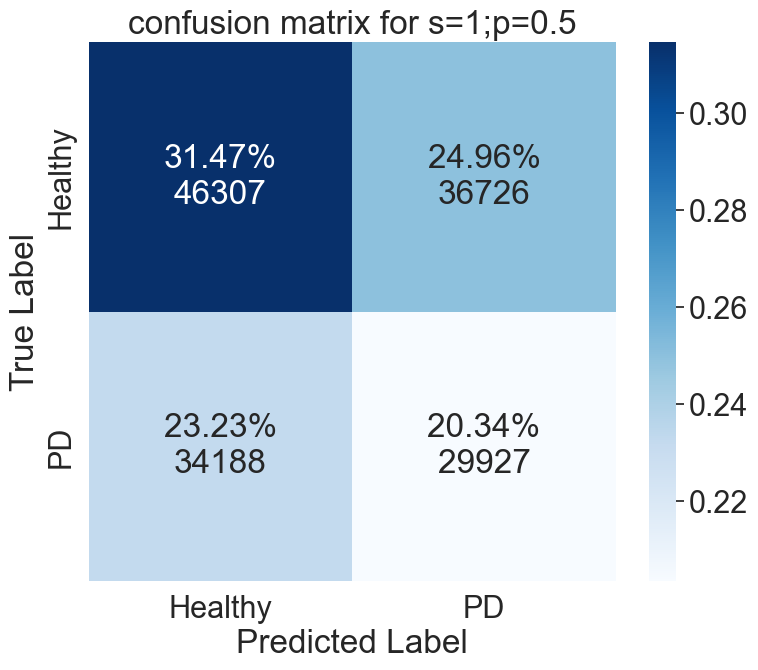

In [15]:
plt.figure(figsize=(8.5, 7))
sns.set(font_scale=2)
group_counts = ["{0:0.0f}".format(value) for value in
                overall_confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     overall_confusion_matrix.flatten()/np.sum(overall_confusion_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_percentages, group_counts)]
labels = np.asarray(labels).reshape(2,2)
group_titles = ['Healthy', 'PD']
cf = sns.heatmap(overall_confusion_matrix/np.sum(overall_confusion_matrix), annot=labels, 
            fmt='', xticklabels=group_titles ,yticklabels=group_titles, cmap='Blues')
cf.set(xlabel='Predicted Label', ylabel='True Label', title=rf'confusion matrix for s={sample_length};p={proba}')
cf.figure.savefig(rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\results\cf", format='svg') 


## Calculation of average feature weights

In [16]:
def mean_weights(df, model):
    weights = np.zeros((len(df.columns)-2))
    cnt = 0
    for i, group in enumerate(groups):
        for j, subject in enumerate(group):
            #xgb_model = joblib.load(rf"{models_path}\{subject}") 
            weights+=np.array(model.feature_importances_)
            cnt+=1
    if cnt == 0:
        return 0
    else:
        return weights/cnt

In [17]:
#original code from https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
def add_labels(x,y):
    for i in range(len(x)):
        text = rf"{x[i]:0.2}"
        if x[i] <= 0.025:
            plt.text(x[i]+0.001, y[i]-0.2, text, ha = 'left',fontsize=10, color ='black')
        else:
            plt.text(x[i]-0.001, y[i]-0.2, text, ha = 'right',fontsize=10, color ='white')

<Figure size 2400x1000 with 0 Axes>

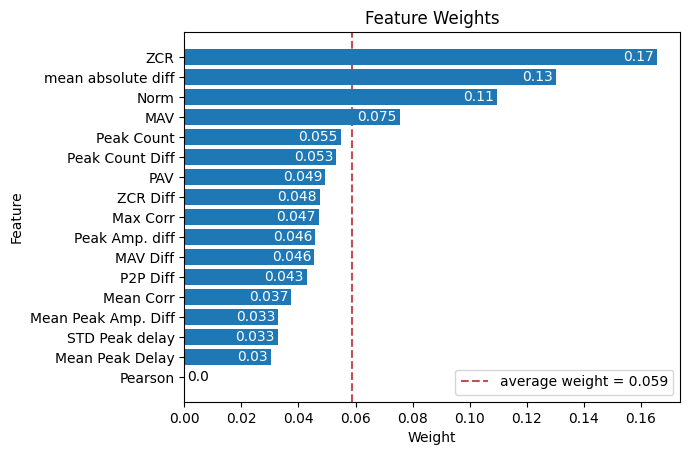

In [18]:
plt.rcdefaults()
plt.figure(figsize=(24, 10))
weights = mean_weights(df, xgb_model)
features = df.columns.tolist()
sorted_weights = np.sort(weights)
sorted_columns = []
for i in range(len(weights)):
    sorted_columns.append(features[2+np.where(weights == sorted_weights[i])[0][0]])
fig, ax = plt.subplots()
weight_pd = pd.Series(weights/43, index=df.columns.tolist()[2:])
plt.barh(range(len(weights)),sorted_weights)
plt.yticks(range(len(weights)), sorted_columns)
ax.set_title(rf"Feature Weights")
ax.set_ylabel("Feature")
ax.set_xlabel("Weight")
add_labels(sorted_weights, range(len(weights)))
plt.axvline(x =1/len(weights), color = 'r', label = rf'average weight = {(1/len(weights)):0.2}', linestyle='--', zorder = -1)
plt.legend(loc = 'lower right')
plt.savefig(rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\results\feature_weights", format = 'svg')

## Violin Plot

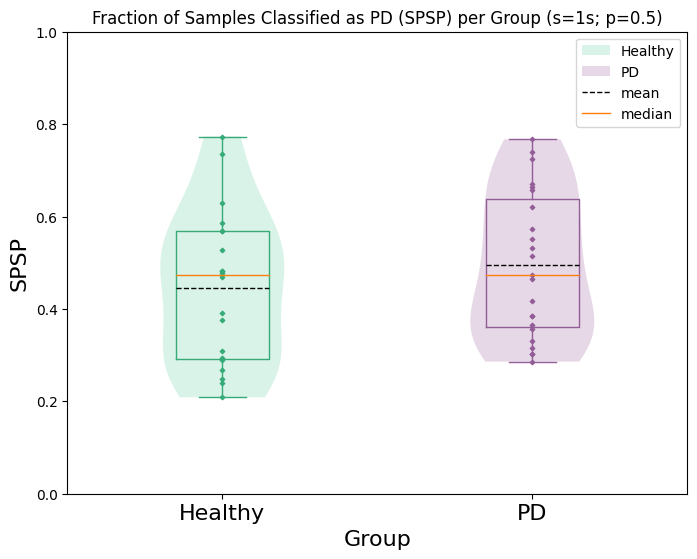

In [19]:
plt.rcdefaults()
plt.figure(figsize=(8, 6))
vplot = plt.violinplot(parkinsons_percent, 
                        widths = 0.4, showextrema = False)
s_colors = ['#82D9B3', '#AD81B1']
l_colors = ['#36AB78','#935D98']

for i,violin in enumerate(vplot['bodies']):
    violin.set_facecolor(s_colors[i])


# vplot['cmaxes'].set_edgecolors(l_colors)
# vplot['cmins'].set_edgecolors(l_colors)
# vplot['cmeans'].set_edgecolors(l_colors)
# vplot['cbars'].set_edgecolors(l_colors)
# vplot['cmeans'].set_edgecolors(["black","black"])

# vplot['cmeans'].set_linestyle(["--","--"])
# vplot['cmedians'].set_edgecolors(["orange","orange"])

bplot1 = plt.boxplot(parkinsons_percent[0], positions =[1], widths = 0.3, showmeans = True, meanline=True,
                    whiskerprops=dict(color=l_colors[0], linewidth = 1),
                    boxprops=dict(color=l_colors[0], linewidth = 1),
                    capprops=dict(color=l_colors[0], linewidth = 1),
                    meanprops=dict(color='black'))
bplot2 = plt.boxplot(parkinsons_percent[1], positions = [2], widths = 0.3,showmeans = True, meanline=True,
                    whiskerprops=dict(color=l_colors[1] ,linewidth = 1),
                    boxprops=dict(color=l_colors[1] ,linewidth = 1),
                    capprops=dict(color=l_colors[0], linewidth = 1),
                    meanprops=dict(color='black'))

for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bplot1[item], color=l_colors[0])
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bplot2[item], color=l_colors[1])

plt.scatter([1]*20, parkinsons_percent[0], marker='D', s=5, color=l_colors[0], zorder = 2)
plt.scatter([2]*23, parkinsons_percent[1], marker='D', s=5, color=l_colors[1], zorder = 2)
plt.ylim((0,1))
plt.xticks([1,2],['Healthy', 'PD'],fontsize = 16)
plt.xlabel('Group', fontsize = 16)
plt.ylabel('SPSP', fontsize = 16)
plt.legend([vplot["bodies"][0], vplot["bodies"][1], bplot1['means'][0], bplot1['medians'][0]], ['Healthy', 'PD', 'mean', 'median'])

#plt.legend([vplot["bodies"][0], vplot["bodies"][1], vplot['cmeans'], vplot['cmedians']], ['Healthy', 'PD', 'mean', 'median'], loc='upper left')
plt.title(rf'Fraction of Samples Classified as PD (SPSP) per Group (s={sample_length}s; p={proba})')
plt.savefig(rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\results\violin_{math.floor(proba*100)}", format = 'svg')

### Plot an ROC curve

In [21]:
true_y = []
predicted_y = []
confidence_in_prediction = []
for i, group in enumerate(groups):
    for j, subject in enumerate(group):
        xgb_model = joblib.load(rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\{subject}") 
        train_data, test_data = leave_one_out(df ,subject)
        #Calculate the number of samples for each group
        train_data = equalize_group_sizes(train_data)
        #shuffle rows
        train_data = train_data.sample(frac = 1)
        X_train, y_train, X_test, y_test = seperate_samples_from_labels(train_data, test_data)
        y_score = xgb_model.predict_proba(X_test)[:, 1]
        true_y = np.concatenate((true_y,y_test.tolist()))
        predicted_y = np.concatenate((predicted_y,y_score))

fpr, tpr, thresholds = metrics.roc_curve(true_y, predicted_y, pos_label=2)

d:\user\Documents\sleep-eeg-processing\venv\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


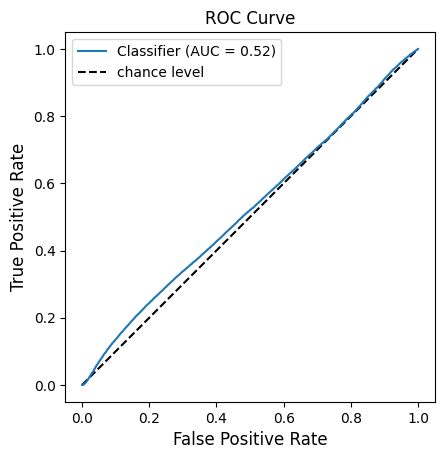

In [22]:
from sklearn.metrics import RocCurveDisplay
plt.rcdefaults()
RocCurveDisplay.from_predictions(
    true_y,
    predicted_y,
)

plt.plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100),color='black', linestyle='--',zorder=-1, label = 'chance level')
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 12)
plt.title("ROC Curve")

plt.legend()
plt.savefig(rf"D:\eeg\maya\data\results\over_all_subs\ROC_17_orig", format='svg')

In [23]:
pp_df = pd.DataFrame(columns=['Subject', 'Group', 'SPSP'])
for i, group in enumerate(groups):
    for j,sub in enumerate(group):
        pp_df.loc[len(pp_df)] = [sub, group_names[i], parkinsons_percent[i][j]]
pp_df.to_csv(rf"D:\eeg\maya\data\results\over_all_subs\csv_13_proba_is_50.csv")

### Box plot only

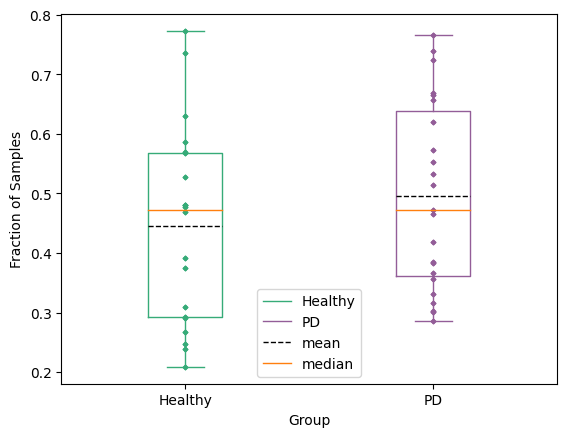

In [24]:
bplot1 = plt.boxplot(parkinsons_percent[0], positions =[1], widths = 0.3, showmeans = True, meanline=True,
                    whiskerprops=dict(color=l_colors[0], linewidth = 1),
                    boxprops=dict(color=l_colors[0], linewidth = 1),
                    capprops=dict(color=l_colors[0], linewidth = 1),
                    meanprops=dict(color='black'))
bplot2 = plt.boxplot(parkinsons_percent[1], positions = [2], widths = 0.3,showmeans = True, meanline=True,
                    whiskerprops=dict(color=l_colors[1] ,linewidth = 1),
                    boxprops=dict(color=l_colors[1] ,linewidth = 1),
                    capprops=dict(color=l_colors[0], linewidth = 1),
                    meanprops=dict(color='black'))

for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bplot1[item], color=l_colors[0])
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bplot2[item], color=l_colors[1])

plt.scatter([1]*20, parkinsons_percent[0], marker='D', s=5, color=l_colors[0], zorder = 2)
plt.scatter([2]*23, parkinsons_percent[1], marker='D', s=5, color=l_colors[1], zorder = 2)

plt.xticks([1,2], ['Healthy', 'PD'])
plt.xlabel('Group')
plt.ylabel('Fraction of Samples')
plt.scatter([1]*20, parkinsons_percent[0], marker='D', s=5, color=l_colors[0], zorder = 2)
plt.scatter([2]*23, parkinsons_percent[1], marker='D', s=5, color=l_colors[1], zorder = 2)
plt.legend([bplot1["boxes"][0], bplot2["boxes"][0], bplot1['means'][0], bplot1['medians'][0]], ['Healthy', 'PD', 'mean', 'median'])
plt.savefig(rf"D:\eeg\maya\data\results\box", format = 'svg')

## Results as a function of proba

In [25]:
#i = group in {0,1}
# j = subject index in group array
# k = proba 
probas = np.arange(0.01,0.95,0.01)
l = len(probas)
c_acc = c_p = np.zeros((20,l))
p_acc = p_p = np.zeros((23,l))
results = [c_acc, p_acc]
pp = [c_p, p_p]
for i, group in enumerate(groups):
    for j, subject in enumerate(group):
        xgb_model = joblib.load(rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\{subject}") 
        train_data, test_data = leave_one_out(df ,subject)
        #Calculate the number of samples for each group
        train_data = equalize_group_sizes(train_data)
        #shuffle rows
        train_data = train_data.sample(frac = 1)
        X_train, y_train, X_test, y_test = seperate_samples_from_labels(train_data, test_data)
        for k, proba in enumerate(probas):
            accuracy = evaluate_proba(xgb_model, X_test, i, proba)
            results[i][j][k] = evaluate_proba(xgb_model, X_test, i, proba)
            pp[i][j][k] = accuracy if i == 1 else 1-accuracy

In [26]:
c = np.mean(c_p, 0)
p = np.mean(p_p, 0)

In [27]:
probas[np.where(p-c == max(p-c))]

array([0.59])

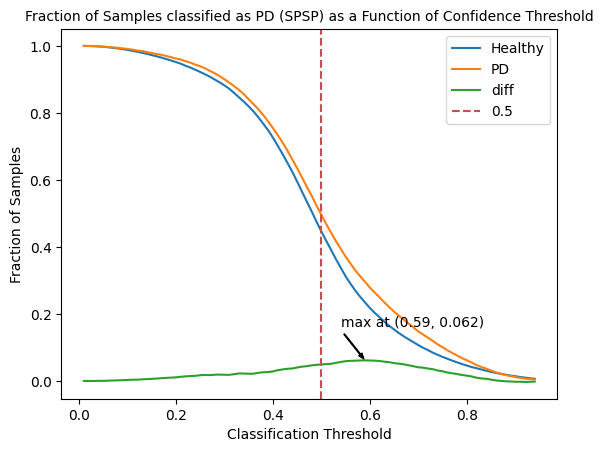

In [28]:
c = np.mean(c_p, 0)
p = np.mean(p_p, 0)
plt.rcdefaults()
r_diff = p-c
xmax = probas[np.where(r_diff == max(r_diff))][0]
xmax_display = round(xmax, 3)
ymax = max(r_diff)
ymax_display = round(ymax, 3)
plt.plot(probas,c, label = 'Healthy')
plt.plot(probas,p, label = 'PD')
plt.plot(probas,r_diff, label = 'diff')
plt.title('Fraction of Samples classified as PD (SPSP) as a Function of Confidence Threshold', fontsize = 10)
plt.axvline(x=0.5, color='r', linestyle='--', label = '0.5')
plt.legend()
plt.annotate(rf'max at {xmax_display, ymax_display}', xy=(xmax, ymax), xytext=(xmax-0.05, ymax+0.1),
            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.5, headlength = 4, headwidth = 3))
plt.xlabel('Classification Threshold')
plt.ylabel('Fraction of Samples')
plt.savefig(rf"D:\eeg\maya\data\models\{sample_length}s_samples\{model}\results\frac_by_proba_(s={sample_length})", format = 'svg')